# Double Machine Learning (DML) — Simulation Notebook

**What this notebook demonstrates**
- Simulating data with treatment, outcome, and confounders.
- Estimating treatment effects robustly with **Double Machine Learning (DML)**.
- Using **orthogonal (Neyman-orthogonal) score construction** and **cross-fitting** to reduce bias from flexible ML models in nuisance estimation.
- Interpreting results with **ATE** and optional **heterogeneous effects (CATE)** using `econml`.

**Reading guide**
1. *Problem Setup:* DGP, variables, and assumptions (unconfoundedness, overlap).
2. *Nuisance Models:* ML models for treatment and outcome.
3. *DML Core:* Residualization, cross-fitting, orthogonal score.
4. *Estimation & Inference:* ATE (and optionally CATE) with standard errors.
5. *Diagnostics & Robustness:* Overlap checks, sensitivity to learners, placebo test.
6. *Takeaways:* What the result means and how to communicate it in a report/CV.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
import seaborn as sns
from econml.dml import LinearDML
from scipy.special import expit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

**Simple Function**
- Here we simulate the outcome of the estimate effects using simple regression, fwl, and dml
- Consistent estimate shows all the methods correctly estimate the desired effects

In [8]:
np.random.seed(534)

df = pd.DataFrame(columns = ['Confounder', 'Treatment', 'Outcome'])
df['Confounder'] = np.random.normal(loc = 100, scale=25, size = 25000)
df['Treatment'] = np.random.normal(loc = 50, scale = 10, size = 25000) + 0.5 * df['Confounder']
df['Outcome'] = 0.25 * df['Confounder'] + 0.75 * df['Treatment'] + np.random.normal(loc=0, scale=5, size=25000)

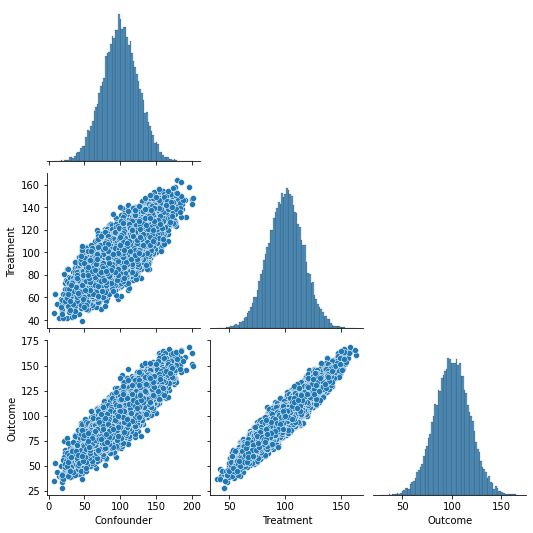

In [9]:
sns.pairplot(df, corner = True)
plt.show()

In [10]:
y = df['Outcome']
X = df[['Confounder', 'Treatment']]

model = RidgeCV()
model = model.fit(X, y)

ate_lr = round(model.coef_[1], 2)

print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 0.75


In [11]:
treatment = df['Treatment'].to_numpy().reshape(-1, 1)
outcome = df['Outcome'].to_numpy().reshape(-1, 1)
confounder = df['Confounder'].to_numpy().reshape(-1, 1)

In [12]:
treatment_model = RidgeCV()
treatment_model = treatment_model.fit(confounder, treatment)
treatment_pred = treatment_model.predict(confounder)
treatment_residuals = treatment - treatment_pred

outcome_model = RidgeCV()
outcome_model = outcome_model.fit(confounder, outcome)
outcome_pred = outcome_model.predict(confounder)
outcome_residuals = outcome - outcome_pred

final_model = RidgeCV()
final_model = final_model.fit(treatment_residuals, outcome_residuals)
ate_fwl = round(final_model.coef_[0][0], 2)

print(f'The average treatment effect is: {ate_fwl}')

The average treatment effect is: 0.75


In [15]:
dml = LinearDML(discrete_treatment=False)

dml.fit(
    df['Outcome'].to_numpy().ravel(),       # make 1D
    T=df['Treatment'].to_numpy().ravel(),   # make 1D
    X=None,
    W=df['Confounder'].to_numpy().reshape(-1,1)  # W can stay 2D since it’s covariates
)

ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.75


**Context for this section — Nuisance modeling**  
Here we fit flexible models for the outcome `E[Y|X,T]` and the treatment `E[T|X]` (or `P(T=1|X)` for binary T).  
These are *nuisance* because they are not the final target, but accurate nuisance estimation is crucial for valid DML.

**Good practice**
- Use proper **train/validation** (or cross-fitting) to avoid leakage.
- Tune hyperparameters (grid/random/Bayesian search).
- Log performance (e.g., RMSE/AUC) to monitor quality.


### Complicated Nuisance Function

**More complex function with particularly complicated nuisance function**
- function contains multiple functions and nonlinear complicated relationships
- double machine learning should uncover these relationships


In [17]:
n=250000
p=10
X = np.random.uniform(size = n*p).reshape((n,-1))

b = (
    np.sin(np.pi * X[:, 0] * X[:, 1])
    + 2 * (X[:, 2] - 0.5) ** 2
    + X[:, 3]
    + 0.5 * X[:, 4]
    + X[:, 5] * X[:, 6]
    + X[:, 7] ** 3
    + np.sin(np.pi * X[:, 8] * X[:, 9])    
)

T = np.random.binomial(1, expit(b))
tau = 0.75
y = b + T * tau + np.random.normal(size = n)

In [18]:
X_T = np.append(X, T.reshape(-1, 1), axis = 1)

model = RidgeCV()
model = model.fit(X_T, y)
y_pred = model.predict(X_T)

ate_lr = round(model.coef_[-1], 2)

print(f'The average treatment effect with LR is {ate_lr}')

The average treatment effect with LR is 0.87


**What DML does here**  
- Residualizes **Y** and **T** using the nuisance models to remove the part explained by **X**.  
- Regresses residualized **Y** on residualized **T** to estimate the **Average Treatment Effect (ATE)**.  
- Uses **cross-fitting** to reduce overfitting bias.

**Key assumptions**
- **Unconfoundedness:** all confounders are observed in **X**.  
- **Overlap:** for all **x**, treatment assignment probability stays away from 0 and 1.

We’ll also add quick diagnostics below to sanity-check overlap and nuisance quality.


### Using DML

In [19]:
dml = LinearDML(model_y = RandomForestRegressor(), model_t=RandomForestClassifier(), discrete_treatment=True)
dml.fit(y, T=T, X=None, W=X)

ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.77


**EconML integration**  
This section uses `econml` estimators (e.g., `LinearDML`, `DMLCateEstimator`) to:  
- Obtain ATE and **CATE** (heterogeneous effects).  
- Leverage built-in cross-fitting and inference routines.  

**Tip for reporting**  
If you include CATE, add a brief explanation (e.g., effect varies with income or baseline risk) and a simple plot with confidence bands.


### EconML

**Interpreting residuals**  
After nuisance modeling, residuals should be *approximately orthogonal* to features **X**.  
Quick checks:  
- Correlation between residuals and high-variance features should be small.  
- Visual inspection can reveal misspecification (non-random patterns).

If diagnostics fail, revisit model choice, features, or regularization.


### Residual

In [20]:
model = RandomForestRegressor()

In [21]:
model.fit(X_T, y)

RandomForestRegressor()

In [22]:
y_hat = model.predict(X_T)

In [23]:
clf = RandomForestClassifier()
clf.fit(X_T, T)

t_hat = clf.predict(X_T)

In [24]:
residual_y = y - y_hat
residual_t = T - t_hat

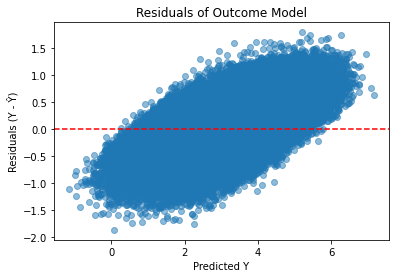

In [25]:
import matplotlib.pyplot as plt

# Residuals for Y
plt.figure()
plt.scatter(y_hat, residual_y, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of Outcome Model")
plt.xlabel("Predicted Y")
plt.ylabel("Residuals (Y - Ŷ)")
plt.show()

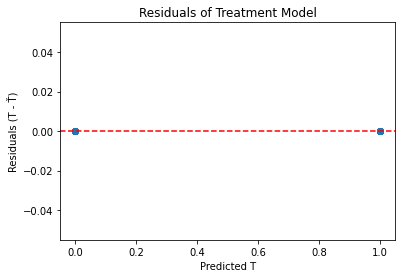

In [26]:
# Residuals for T
plt.figure()
plt.scatter(t_hat, residual_t, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of Treatment Model")
plt.xlabel("Predicted T")
plt.ylabel("Residuals (T - Ť)")
plt.show()

## Diagnostics & Robustness (Added)

- **Overlap check (binary T):** histogram of predicted propensity `P(T=1|X)`; avoid mass near 0 or 1.  
- **Nuisance quality:** report RMSE (outcome) and AUC/Brier (treatment) on validation folds.  
- **Sensitivity to learners:** re-estimate ATE with (a) tree-based, (b) linear, (c) boosted learners; compare.  
- **Placebo test:** randomly permute T; estimate ATE — should be near 0.  
- **Stability:** bootstrap confidence intervals for ATE; ensure stable sign/magnitude.

> These can be implemented in separate helper functions for clean structure.


## Takeaways & Communication (Added)

- **Plain-language result:** State the estimated ATE with a confidence interval and the practical meaning.  
- **Assumptions reminder:** Note unconfoundedness and overlap; mention key covariates that make this plausible.  
- **Limits:** Simulation validates method behavior; real data may violate assumptions; include robustness checks.  
- **Portfolio framing:** Emphasize you implemented modern causal ML (**DML**), set up cross-fitting, validated assumptions, and interpreted policy-relevant effects.


## Reproducibility (Added)

- Fixed random seed.  
- List package versions (`pip freeze | grep -E "numpy|pandas|sklearn|econml|matplotlib|xgboost"`).  
- Clear cell ordering; no hidden state between runs.
